In [415]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [416]:
%reset -sf

In [417]:
import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import DM_plt_prefs
DM_plt_prefs()
import matplotlib.pyplot as plt
import os
import cProfile
import numpy as np
import builtins
from scipy import sparse as scisp
from scipy import optimize as sopt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer

from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord
np.random.seed(0)
coord.Galactic()
%cd ~/DeprojectionProject/

/Users/danielmikkola/DeprojectionProject


In [425]:
%cd ~/Documents/faststats/faststats/
from fkde import *
def kdeplot(x,y,grid,no_c,bw_a):
    Z,ax = fastkde(x,y,gridsize=grid,nocorrelation=no_c,adjust=bw_a)#,weights,adjust)
    xlen,ylen = np.shape(Z)
    X,Y = np.meshgrid(np.linspace(ax[0],ax[1],xlen),np.linspace(ax[0],ax[1],ylen))
    return X,Y,Z
%cd ~/DeprojectionProject/

/Users/danielmikkola/Documents/faststats/faststats
/Users/danielmikkola/DeprojectionProject


In [418]:
def rot(x,y,deg):
    xf = x.flatten(); xf = xf.reshape(len(xf),1)
    yf = y.flatten(); yf = yf.reshape(len(yf),1)
    pos = np.hstack((xf,yf))
    
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    pos = np.dot(pos, R.T)
    
    x = pos[:,0].reshape(x.shape)
    y = pos[:,1].reshape(y.shape)
    return x,y

def f(x,y,z,lim):
    x,y = rot(x,y,45)
    val = (lim-np.abs(x))**4 + (lim-np.abs(y))**4 + (lim-np.abs(z))**4
    return val/np.sum(val)


def pyramid_sample(N_sample,r,c):
    # Velocities
    xc,yc,zc = c
    N = 100
    X = np.linspace(-r,r,N)
    Y = np.linspace(-r,r,N)
    Z = np.linspace(-r,r,N)
    
    XX = X.reshape(1,N,1)*np.ones((N,1,N))
    YY = Y.reshape(N,1,1)*np.ones((1,N,N))
    ZZ = Z.reshape(1,1,N)*np.ones((N,N,1))
    
    P = f(XX,YY,ZZ,r+np.max(c))
    
    rrind = np.ravel_multi_index(np.indices(XX.shape), XX.shape).ravel()
    prob = np.ravel(P)
    smp = np.random.choice(rrind, size=N_sample, p=prob)
    smpx, smpy, smpz = np.asarray(np.unravel_index(smp, XX.shape))
    
    XX = XX + xc
    ZZ = YY + yc
    YY = ZZ + zc
    
    vxvals = XX[smpx, smpy, smpz]
    vyvals = YY[smpx, smpy, smpz]
    vzvals = ZZ[smpx, smpy, smpz]
    
    # Positions
    xmax, ymax, zmax = np.array([100,100,100])/np.sqrt(3)    
    xmin, ymin, zmin = -xmax,-ymax,-zmax
    
    xvals = (np.random.rand(N_sample) * (xmax - xmin) + xmin)
    yvals = (np.random.rand(N_sample) * (ymax - ymin) + ymin)
    zvals = (np.random.rand(N_sample) * (zmax - zmin) + zmin)
    return xvals, yvals, zvals, vxvals, vyvals, vzvals

## Generate gaussian sample

In [419]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate pyramid-like sample from distribution

In [ ]:
x, y, z, vx, vy, vz = pyramid_sample(int(1e4),100, c=(0,0,0))

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)



In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Generate  fake Galactic samples

From simulated galaxy:

Loading data

In [ ]:
N = 5000 #Number of stars we want to use in our sample
dat = np.load('DATA/simgal.npy')

Select a sample around with radius 2 kpc around 8 kpc

In [ ]:
x,y,z,vx,vy,vz = dat
R = np.sqrt((x-8)**2 + y**2)
snbh = R < 2
dat = dat[:,snbh]
I = np.random.randint(low=0,high=np.sum(snbh),size=N)

x,y,z,vx,vy,vz = dat[:,I]

# Center x, y and vy, so they look like they're relative to the LSR
x = x - np.median(x)
y = y - np.median(y)
vy = vy - np.median(vy)

Prepare for astropy

In [ ]:
x,y,z          = (x,y,z)* u.pc
vx,vy,vz       = (vx,vy,vz) * (u.km / u.s)

In [ ]:
# We use Astropy's coord class which makes it easy to keep track of units and conversions

sample = coord.Galactic(u=x,
                         v=y, 
                         w=z,
                         U=vx,
                         V=vy,
                         W=vz,
                         representation_type=coord.CartesianRepresentation,
                         differential_type=coord.CartesianDifferential)
sample.set_representation_cls(coord.SphericalRepresentation, coord.SphericalCosLatDifferential)


In [ ]:
pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

## Inspect sample

In [ ]:
plt.hist2d(np.array(sample.l),np.array(sample.b),100)
plt.show()

In [420]:
n = np.array([20,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

alpha_guess = 1e-8
v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

In [421]:
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)

sigma = np.sqrt(sigma2)
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)

sanity_check(pvals,rhatvals,phi0,vmin,dv,n)


DB98 mean                  : ===> [ 9.243373 -0.868939  9.42836 ]
computed f(v) mean         : ===> [-0.407224  4.752244  4.684499]
DB98 dispersions           : ===> [27.232702 29.733462 28.126512]
Computed f(v) dispersions  : ===> [49.957816 48.86752  49.277264]




In [423]:
t0 = timer()
mxl, phi_all, fmin_it = max_L(alpha_guess, pvals, rhatvals, vmin, dv, n, v0_guess = v_guess, disp_guess = disp_guess)
time = str((timer() - t0)/60); print(time + ' mins')

sanity_check(pvals,rhatvals,mxl,vmin,dv,n)

Allocated RAM: 5.57 GB  
Required RAM : 0.32 GB | Block size = 87040
Fast Numpy Kvals run possible, running...

Finished kvals.

Started fmin_cg... Finished!
Optimization terminated sucessfully.
         Current function value : 10.336173
         Iterations             : 855
         Function evaluations   : 3406
         Gradient evaluations   : 3406

0.8848389987000701 mins

DB98 mean                  : ===> [ 9.243373 -0.868939  9.42836 ]
computed f(v) mean         : ===> [ 9.153985 -1.289587  9.284526]
DB98 dispersions           : ===> [27.232702 29.733462 28.126512]
Computed f(v) dispersions  : ===> [29.148557 31.266463 30.075922]




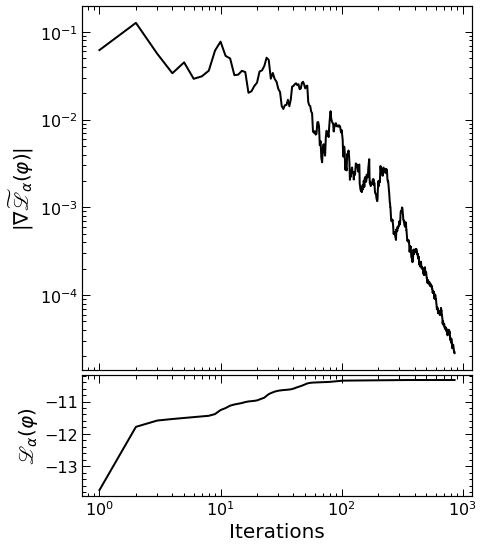

In [470]:
def plot_L_and_dL():
    f,ax = plt.subplots(2,1,figsize=(7,9),sharex=True,frameon=False,gridspec_kw={'height_ratios':[3,1]})

    ax[0].plot(range(1,len(gradL)+1),gradL,'k-',linewidth=2)
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    #ax[0].set_ylabel('$|\\nabla\tilde{\mathscr{L}}_\alpha(\\varphi)|$')
    ax[0].set_ylabel('$|\\nabla\\widetilde{\mathscr{L}}_\\alpha(\\varphi)|$')

    ax[1].set_ylabel('$\mathscr{L}_\\alpha(\\varphi)$')
    ax[1].plot(range(1,len(L)+1),L,'k-',linewidth=2)
    ax[1].set_xlabel('Iterations')
    ax[1].set_xscale('log')
    plt.subplots_adjust(hspace=0.02)
    
    if logging:
        plt.savefig('RUNS/' + folder + '/LanddLplot' + '.pdf',format='pdf')
    try:
        autoplot
    except NameError:
        plt.show()

    return

In [465]:
L

array([-13.73207764, -11.7811701 , -11.58656032, -11.53918311,
       -11.50725147, -11.47836076, -11.4615325 , -11.43957096,
       -11.38699187, -11.2633143 , -11.20211489, -11.12715557,
       -11.09157532, -11.06731473, -11.04633009, -11.01573623,
       -10.9979006 , -10.9889065 , -10.97918387, -10.96502279,
       -10.93457118, -10.90604278, -10.8806297 , -10.82260702,
       -10.7729187 , -10.74154669, -10.71599313, -10.69424522,
       -10.67925341, -10.66603206, -10.6572452 , -10.65180422,
       -10.64797241, -10.64429535, -10.63926619, -10.63412641,
       -10.62885985, -10.6239153 , -10.61462821, -10.60200647,
       -10.58926968, -10.57216799, -10.55989119, -10.54810248,
       -10.53498167, -10.52497076, -10.51124942, -10.4966082 ,
       -10.48085672, -10.46752054, -10.45690082, -10.44264623,
       -10.43427472, -10.4284477 , -10.42385672, -10.41995545,
       -10.41710676, -10.41512259, -10.4139954 , -10.41292071,
       -10.41184266, -10.41079059, -10.40928672, -10.40

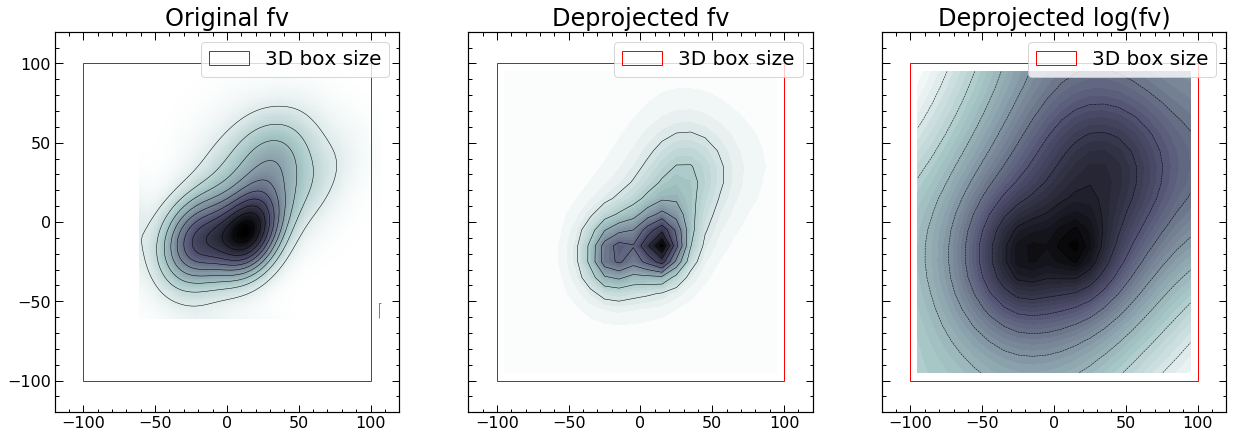

In [426]:
dx, dy = dv[0], dv[1]
vxmin, vymin = vmin[0], vmin[1]
nx, ny = n[0], n[1]
vxmax, vymax = vxmin+nx*dx,vymin+ny*dy

x0, y0 = vxmin, vymin
x1, y1 = vxmax, vymax

xbins = np.arange(x0,x1+dx,dx)
ybins = np.arange(y0,y1+dy,dy)

xc = (xbins[1:]+xbins[:-1])/2
yc = (ybins[1:]+ybins[:-1])/2

[X,Y] = np.meshgrid(xc,yc);

fv = np.exp(mxl)

fvlog = np.log10(fv+1)
xl = 120
yl = 120
twodfv = np.sum(fv,axis=2)


X2,Y2,Z = kdeplot(np.array(vx),np.array(vy),(100,100),False,2)
# Z,xbins,ybins = np.histogram2d(np.array(vx),np.array(vy),20)
# xc = (xbins[1:]+xbins[:-1])/2
# yc = (ybins[1:]+ybins[:-1])/2

# [X2,Y2] = np.meshgrid(xc,yc);

f,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(21,7),frameon=False)

ax[0].contourf(X2,Y2,Z.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
ax[0].pcolormesh(X2,Y2,Z.T,cmap='bone_r')
ax[0].contour(X2,Y2,Z.T,10,origin='lower',colors='k',linewidths=0.5)
ax[0].set_xlim(-xl,xl)
ax[0].set_ylim(-yl,yl)
ax[0].add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
ax[0].legend()
ax[0].set_title('Original fv')

ax[1].contourf(X,Y,twodfv.T,40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
ax[1].contour(X,Y,twodfv.T,10,origin='lower',colors='k',linewidths=0.5)
ax[1].set_xlim(-xl,xl)
ax[1].set_ylim(-yl,yl)
ax[1].add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
ax[1].legend()
ax[1].set_title('Deprojected fv')

ax[2].contourf(X,Y,np.log10(twodfv.T),40,origin='lower',cmap = plt.cm.get_cmap('bone_r'),linestyles='solid')
ax[2].contour(X,Y,np.log10(twodfv.T),10,origin='lower',colors='k',linewidths=0.5)
ax[2].set_xlim(-xl,xl)
ax[2].set_ylim(-yl,yl)
ax[2].add_patch(Rectangle((vmin[0],vmin[1]),n[0]*dv[0],n[0]*dv[0], fill=None,edgecolor='r',label='3D box size'))
ax[2].legend()
ax[2].set_title('Deprojected log(fv)')

plt.show()

In [411]:
# L, gradL             - For each fmin_cg iteration
# L_calls, gradL_calls - For each function and gradient call respectively
# I_its, Ig_its        - Indices of L_calls and gradL_calls that match the iterations

def plot_LanddL():
    I_its = []
    Ig_its = []

    for i, call in enumerate(L_calls):
        if call in L:
            I_its.append(i)
    
    for i, call in enumerate(gradL_calls):
        if call in gradL:
            Ig_its.append(i)


    f,ax = plt.subplots(2,2,figsize=(14,10),sharey='row',frameon=False,gridspec_kw={'height_ratios':[3,1]})

    ax[0,0].set_title('All iterations\n$\\nabla\mathscr{L}(\\varphi)$')
    ax[0,0].plot(gradL_calls[Ig_its],'k-',marker='.',linewidth=1)
    ax[0,0].set_yscale('log')

    ax[1,0].set_title('$\mathscr{L}(\\varphi)$')
    ax[1,0].plot(L_calls[I_its],'k-',marker='.',linewidth=1)
    ax[1,0].set_xlabel('Iterations')

    ax[0,1].set_title('All calls\n $\\nabla\mathscr{L}(\\varphi)$')
    ax[0,1].plot(gradL_calls,'r-',linewidth=1)
    ax[0,1].plot(Ig_its,gradL_calls[Ig_its],'k.')
    ax[0,1].set_yscale('log')
    ax[0,1].set_ylim(gradL_calls.min()*0.1, gradL_calls.max()*1.1)

    # inset axes....
    axins = ax[0,1].inset_axes([0.05, 0.01, 0.90, 0.3])
    axins.plot(gradL_calls,'r-',marker='.',linewidth=1,label='$\\nabla\mathscr{L}(\\varphi)$ calls')
    axins.plot(Ig_its,gradL_calls[Ig_its],'k.',label='$\mathrm{\\tt fmin\_cg()}}$ iterations')

    # sub region of the original image
    x1, x2, y1, y2 = Ig_its[-10], len(gradL_calls), 0.9*gradL_calls[Ig_its[-10]:].min(), 1.1*gradL_calls[Ig_its[-10]:].max()
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_yticklabels('')
    axins.set_xticks([x1,x2])
    axins.xaxis.tick_top()
    #axins.legend(fontsize=14)
    ax[0,1].indicate_inset_zoom(axins)



    ax[1,1].set_title('$\mathscr{L}(\mathscr{\phi})$')
    ax[1,1].plot(L_calls,'r-',linewidth=1,label='$\mathscr{L}(\\varphi)$ calls')
    ax[1,1].plot(I_its,L_calls[I_its],'k.',label='$\mathrm{\\tt fmin\_cg()}}$ iterations')
    ax[1,1].set_xlabel('function calls')
    ax[1,1].legend(fontsize=14)
    plt.show()
    return 

# End of non-testing lines

In [ ]:
import inspect
lines = inspect.getsource(fmin_cg)
%rm fmin_cg_read.py
with open('fmin_cg_read.py','a') as writer:
    writer.write(lines)
os.system('atom fmin_cg_read.py')

Investigating grad_L

## Alternative sec_der

In [ ]:
def plotphi(phi):
    plt.figure(figsize=(4,3))
    im = plt.pcolormesh(phi.T,cmap = plt.cm.get_cmap('viridis'))
    plt.colorbar(im)
    plt.show()

In [ ]:
%cd DATA/
pvals = np.load('TEST/pvals.npy')
rhatvals = np.load('TEST/rhatvals.npy')
mxl = np.load('TEST/mxl.npy')

## Check eq 30 on 1d Gaussian

$$ \Xi_{\pmb{n}\pmb{l}} \propto -2\delta_{\pmb{n},\pmb{l}} + \delta_{\pmb{n},\pmb{l} + \pmb{\hat{e}}_i} + \delta_{\pmb{n},\pmb{l} - \pmb{\hat{e}}_i}$$

$$f(x) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} \rightarrow \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f'(x) =  -\frac{x}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

$$f"(x) =  \frac{x^2 - 1}{\sqrt{2\pi}} e^{-\frac{1}{2}x^2}$$

In [ ]:
%matplotlib inline
from ipywidgets import *

def f_gauss(x):
    return np.exp(-0.5*x**2) / np.sqrt(2*np.pi)

def f_gauss_bis(x):
    return (x**2 - 1)*f_gauss(x)

# def xi_vals(x):
#     phi = np.log(f_gauss(x))
#     sec_vals = (vals[2:] + vals[:-2] - 2*vals[1:-1])
#     return 

def x_vals(N):
    return np.linspace(-5,5,N)

def plot_func(N):
    x = x_vals(int(N))

    plt.plot(x,f_gauss(x),'b')
    plt.plot(x,f_gauss_bis(x),'r')
    #plt.plot(x[1:-1],xi_vals(f_gauss(x)),'g')
    plt.show()

interact(plot_func, N = widgets.FloatSlider(value=50,
                                               min=5,
                                               max=100,
                                               step=5))

In [13]:
%timeit dvx, dvy, dvz = dv; dvx * dvy * dvz
%timeit dv[0] * dv[1] * dv[2]
%timeit np.prod(dv)

892 ns ± 9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
548 ns ± 14.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3.31 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%timeit dv2 = np.square(dv); (dv2[0]*dv2[0]); (dv2[1]*dv2[1]); (dv2[2]*dv2[2])
%timeit dv2 = np.square(dv); dvx, dvy, dvz = dv2; dvx*dvx; dvy*dvy; dvz*dvz

1.57 µs ± 7.18 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.7 µs ± 18.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
def xi_calc(phi, sigma2, dv):
    '''This function calculates eq. 29 (and in turn eq. 30) of WD98. Each cell m has a contribution 
    of -2*phi_m, phi_(m+e_i), and phi_(m-e_i) from itself, its neighbor one step up in the i 
    direction and one step down in the i direction respectively. The direction i loops over
    the x, y, and z directions.
    
    The contributions are added onto a zero array of the same shape as phi and only when 
    both neighbours are available in the given dimension. e.g. there is no x term when
    treating on [1, :, :] or [:, :, -1]
    
    Inputs are:
    
    phi - log of the distribution [nx,ny,nz]
    
    sigma2 - squared dispersion in each direction [array of len 3]
    
    dv - cell widths [array of len 3]
    
    ----
    
    Output is:
    
    phi_arr - The contributions to each cell, equiv. to eq 29 in WD98'''

    phi_arr = np.zeros(phi.shape)

    phi_arr[1:-1,:,:] += (sigma2[0] / (dv[0]*dv[0])) * (-2*phi[1:-1, :, :] + phi[2:, :, :] + phi[:-2, :, :])
    phi_arr[:,1:-1,:] += (sigma2[1] / (dv[1]*dv[1])) * (-2*phi[:, 1:-1, :] + phi[:, 2:, :] + phi[:, :-2, :])
    phi_arr[:,:,1:-1] += (sigma2[2] / (dv[2]*dv[2])) * (-2*phi[:, :, 1:-1] + phi[:, :, 2:] + phi[:, :, :-2])

    return phi_arr

In [380]:
def sec_der(phi, sigma2, dv):
    '''This function calculates eq. 29 (and in turn eq. 30) of WD98. Each cell m has a contribution 
    of -2*phi_m, phi_(m+e_i), and phi_(m-e_i) from itself, its neighbor one step up in the i 
    direction and one step down in the i direction respectively. The direction i loops over
    the x, y, and z directions.
    
    The contributions are added onto a zero array of the same shape as phi and only when 
    both neighbours are available in the given dimension. e.g. there is no x term when
    treating on [1, :, :] or [:, :, -1]
    
    Inputs are:
    
    phi - log of the distribution [nx,ny,nz]
    
    sigma2 - squared dispersion in each direction [array of len 3]
    
    dv - cell widths [array of len 3]
    
    ----
    
    Output is:
    
    phi_arr - The contributions to each cell, equiv. to eq 29 in WD98'''

    phi_arr = np.zeros(phi.shape)

    phi_arr[1:-1,:,:] += (sigma2[0] / (dv[0]*dv[0])) * (-2*phi[1:-1, :, :] + phi[2:, :, :] + phi[:-2, :, :])
    phi_arr[:,1:-1,:] += (sigma2[1] / (dv[1]*dv[1])) * (-2*phi[:, 1:-1, :] + phi[:, 2:, :] + phi[:, :-2, :])
    phi_arr[:,:,1:-1] += (sigma2[2] / (dv[2]*dv[2])) * (-2*phi[:, :, 1:-1] + phi[:, :, 2:] + phi[:, :, :-2])

    return phi_arr

def grad_sec_der(phi, sigma2, dv):
    '''Here we calculate the equivalent factor to sec_der for the gradients third term'''
    
    phi_arr = np.zeros(phi.shape)
    
    phi_arr_loc = sec_der(phi, sigma2, dv) # This gives us the matrix A_m for all m = (i,j,k) cells
    
    # The x contribution
    phi_arr[:-2,:,:]  += 2 * (phi_arr_loc[1:-1,:,:]) * sigma2[0]/(dv[0]*dv[0]) # Adds A_(m-1) contribution
    phi_arr[2:,:,:]   += 2 * (phi_arr_loc[1:-1,:,:]) * sigma2[0]/(dv[0]*dv[0]) # Adds A_(m+1) contribution
    phi_arr[1:-1,:,:] -= 4 * (phi_arr_loc[1:-1,:,:]) * sigma2[0]/(dv[0]*dv[0]) # Adds A_m contribution

    # The y contribution
    phi_arr[:,:-2,:]  += 2 * (phi_arr_loc[:,1:-1,:]) * sigma2[1]/(dv[1]*dv[1]) # Adds A_(m-1) contribution
    phi_arr[:,2:,:]   += 2 * (phi_arr_loc[:,1:-1,:]) * sigma2[1]/(dv[1]*dv[1]) # Adds A_(m+1) contribution
    phi_arr[:,1:-1,:] -= 4 * (phi_arr_loc[:,1:-1,:]) * sigma2[1]/(dv[1]*dv[1]) # Adds A_m contribution

    # The z contribution
    phi_arr[:,:,:-2]  += 2 * (phi_arr_loc[:,:,1:-1]) * sigma2[2]/(dv[2]*dv[2]) # Adds A_(m-1) contribution
    phi_arr[:,:,2:]   += 2 * (phi_arr_loc[:,:,1:-1]) * sigma2[2]/(dv[2]*dv[2]) # Adds A_(m+1) contribution
    phi_arr[:,:,1:-1] -= 4 * (phi_arr_loc[:,:,1:-1]) * sigma2[2]/(dv[2]*dv[2]) # Adds A_m contribution
    
    return phi_arr
    
    

def neg_L_calc(phi, *args):
    """The function that we wish to optimise. Corresponds to eq. 31 in D98.

    N: Number of stars in our sample

    Kvals: Array of dimensions (N,nx,ny,nz) containing the K-values for each star in our sample.

    alpha: Smoothing parameter that can be found using the function opt_alpha
   
    We use sparse matrices in our computation of L_tilde because our K- arrays have low
    density. Therefore we use the scipy.sparse package to convert our arrays to sparse arrays.
    Using coo-matrices is faster when building the matrix, but the csc-matrices are faster for
    arithmetic operations
    
    phi_unr regains the original shape of our phi guess and is used to compute the
    third term of L_tilde."""
    
    Kvals, N, alpha, dv, n, sigma2 = args
    
    exphir = np.exp(phi)
    exphi_csc = scisp.coo_matrix(exphir).tocsc()
    
    Kphi = Kvals.multiply(exphi_csc).sum(axis=1) # Order all Kphi values in 1D arrays and compute the sum of exp(phi)*K(k|l) for each star
    Kphi_sum_tot = np.log(Kphi[Kphi != 0]).sum() # To make sure we don't get infinities and .sum() gives the double sum in the first term
    
    phi_unr = np.reshape(phi, n)
    phixhi_sum = (sec_der(phi_unr, sigma2, dv) ** 2).sum()
    
    t1 = Kphi_sum_tot / N
    t2 = exphi_csc.sum()
    t3 = ((alpha * dv[0] * dv[1] * dv[2]) / 2) * phixhi_sum
    
    L_tilde = t1 - t2 - t3 # eq. 31 in DB98
        
    neg_L = -1 * L_tilde  # Since we want to maximize L_tilde, we should minimize -L_tilde
    return neg_L

def grad_neg_L_calc(phi, *args):
    """In this function we compute the gradient of L. We compute the derivative for each cell and return a
    1D array of length (nx*ny*nz).

    args: see get_L

    """
    Kvals, N, alpha, dv, n, sigma2 = args
    
    
    exphir = np.exp(phi)
    exphi_csc = scisp.coo_matrix(exphir).tocsc()
    
    Kphi = exphi_csc.multiply(Kvals)
    Kphi_sum = Kphi.sum(axis=1)
    Kphi_sum[Kphi_sum.nonzero()] = 1 / Kphi_sum[Kphi_sum.nonzero()] # We compute the sum of exp(phi)*K(k|l) for each star
    K_term0 = Kphi.multiply(Kphi_sum)
    K_term = K_term0.sum(axis=0) # The final array with the first term for each cell
    
    phi_unr = np.reshape(phi,n)
    dphixhi = grad_sec_der(phi_unr, sigma2, dv)   
    
    t1 = K_term/N
    t2 = exphi_csc
    t3 = ((alpha * dv[0] * dv[1] * dv[2]) / 2) * dphixhi.ravel()
    
    grad_L = np.asarray(t1 - t2 - t3).reshape(len(phi), )
    
    neg_grad_L = -1 * grad_L
    return neg_grad_L

In [397]:
N = 5000 #Number of stars we want to use in our sample
sample, vx, vy, vz = Deproject_v1_0.model_sample(N)

pvals, rhatvals = Deproject_v1_0.calc_p_rhat(sample)
sigma2, vmean0 = Deproject_v1_0.calc_sigma2(pvals,rhatvals,True)
sigma = np.sqrt(sigma2)

n = np.array([20,20,20])
dv = np.array([10,10,10])
vmin = np.array([-100,-100,-100])

alpha_guess = 1e-9
v_guess = np.array([1,1,1])
disp_guess = np.array([22,17,30])

Kvals = KvalsNumpyMethod(pvals, rhatvals, vmin, dv, n)

nx, ny, nz = n
phi0 = phi_guess(vmean0,sigma,vmin,dv,n)  
phi0r = np.ravel(phi0)

args = (Kvals, N, alpha_guess, dv, n, sigma2)

In [398]:
print('Started fmin_cg... ',end='')
mxl, fopt, fcalls, gcalls, flag, phi_all = fmin_cg(neg_L_calc, phi0r, fprime=grad_neg_L_calc, gtol=1e-8, args=args, retall=True, disp=False, full_output=True)
print(colored('Finished!','green',attrs=['bold','underline']))
fmin_it = np.shape(phi_all)[0] - 1
fmin_cg_output(fopt, fcalls, gcalls, flag, fmin_it)

Started fmin_cg... Finished!
Optimization terminated sucessfully.
         Current function value : 10.177883
         Iterations             : 1606
         Function evaluations   : 8035
         Gradient evaluations   : 8035



In [401]:
def nonp():
    x = []
    for i in range(1000):
        x.append(i)
    x = np.asarray(x)
    return x

def withnp():
    x = np.array([])
    for i in range(1000):
        x = np.append(x,i)
    return x

In [407]:
x_a = nonp()
x_b = withnp()

In [409]:
%%timeit
x = []
for i in range(1000):
    x.append((((i**2)**0.5)**2)**0.5)
x = np.asarray(x)

510 µs ± 8.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [410]:
%%timeit
x = np.array([])
for i in range(1000):
    x = np.append(x,(((i**2)**0.5)**2)**0.5)

4.97 ms ± 91.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [408]:
print(type(x_a),x_a.shape)
print(type(x_b),x_b.shape)

<class 'numpy.ndarray'> (1000,)
<class 'numpy.ndarray'> (1000,)
